In [2]:
# import sys
import numpy as np
import chainer
import chainer.functions as F
from chainer import cuda, Function, FunctionSet, gradient_check, Variable, optimizers
from matplotlib import pyplot as plt
from PIL import Image
import cPickle as pickle
cuda.init()

%matplotlib inline

patch_size = 15
parentpath= '/home/koyama-m/Research/membrane_CNN/'
models_path='/home/koyama-m/Research/membrane_CNN/models/'

sys.path.append(parentpath)
sys.path.append(models_path)

reconstruction_path = '/home/koyama-m/Research/membrane_CNN/data/reconstructed_256images_crop15'
probmap_prefix = 'multi_crop_prediction_image_256_'
binmap_prefix = 'multi_crop_prediction_binary_image_256_' 

#LOAD MODEL
modelname = 'hole0_cool_rate0.95conditional_distr_trained_model256_crop15epoch80.pkl'
modelname = 'hole7_cool_rate0.95conditional_distr_trained_model256_crop15epoch80.pkl'

print models_path +modelname

model = pickle.load(open(models_path +modelname ))
model = model.to_gpu()

/home/koyama-m/Research/membrane_CNN/models/hole7_cool_rate0.95conditional_distr_trained_model256_crop15epoch80.pkl


(241, 241)


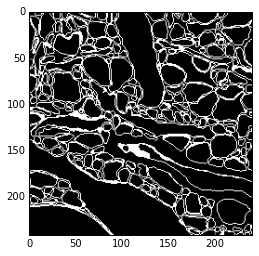

In [3]:
#PARAMETER
patchsize = 15
init_heat = 300
cooldown = 0.95

#TARGET FILE
index = "001"
filename = 'edgemap%s.tif' % index
filename2 = 'pooled_image_%s.tif'% index
filename3 = 'multi_crop_prediction_binary_image_256_%s.tif'% index

label_data_dir  = 'raw/train-labels'
raw256path ="preprocessed/training/pooled_training_dataset"
crop15init_image_path = "reconstructed_256images_crop15"  

testimage=  Image.open("%s/data/%s/%s" % (parentpath, raw256path, filename2))
testlabel =Image.open("%s/data/%s/%s" % (parentpath, label_data_dir, filename))
test_reconstruct = Image.open("%sdata/%s/%s" % (parentpath, crop15init_image_path, filename3))

#CNN Cropped the images. I must register the image with the cropped version. 
crop_cornerX = patchsize/2
crop_cornerY = patchsize/2
crop_range = (crop_cornerX, crop_cornerY, 256-crop_cornerX-1,  256-crop_cornerX-1)

testimage= testimage.crop(crop_range) 
testlabel= testlabel.crop(crop_range) 


#CONVERT FILE to READABLE FORM
testimage_array = np.array(list(testimage.getdata()))
testlabel_array = np.array(list(testlabel.getdata()))
test_reconstruct_array = np.array(list(test_reconstruct.getdata()))

new_reconstr = test_reconstruct_array.copy().reshape(np.sqrt(testimage_array.shape[0]), np.sqrt(testimage_array.shape[0]))/255.
original_2darray = new_reconstr.copy()
true_2darray = testlabel_array.copy().reshape(np.sqrt(testimage_array.shape[0]), np.sqrt(testimage_array.shape[0]))/255.

raw_2darray = testimage_array.reshape(np.sqrt(testimage_array.shape[0]), np.sqrt(testimage_array.shape[0]))/255.

#
print new_reconstr.shape
#plt.imshow(new_reconstr, cmap = plt.cm.gray)
plt.imshow(true_2darray, cmap = plt.cm.gray)

In [4]:
modelcpu = model.to_cpu()

In [10]:
#reinitialize
new_reconstr = original_2darray.copy()
gibbpatch = 25
#new_reconstr = true_2darray.copy()
#LOAD MODEL
modelname = 'hole0_cool_rate0.95conditional_distr_trained_model256_crop%sepoch80.pkl' %gibbpatch
print models_path +modelname
model = pickle.load(open(models_path +modelname ))
model = model.to_cpu()


num_iter = 150
heatnow = 1
cooldown = 0.9
threshold = 0.2
for iter in range(0, num_iter):
    N_gibb_batch = 200
    cornerX = np.random.choice(np.array(range(0,new_reconstr.shape[0]-gibbpatch)), N_gibb_batch)
    cornerY=  np.random.choice(np.array(range(0,new_reconstr.shape[0]-gibbpatch)), N_gibb_batch)
    #Coordinates subject to change 
    coords = np.concatenate((cornerX.reshape(N_gibb_batch,1), cornerY.reshape(N_gibb_batch,1)), axis = 1)
    localcenter = np.ones([N_gibb_batch, 2], int)*7
    centers = coords + localcenter
    centers[0], coords[0]
    
    gibb_batch_x = np.zeros([N_gibb_batch, 2, gibbpatch , gibbpatch ],'float32')  
    for k in range(0, N_gibb_batch):
            corner_x, corner_y = coords[k]
            yrange = np.array(range(corner_y, corner_y +gibbpatch))
            xrange = np.array(range(corner_x, corner_x + gibbpatch))
            patch_raw = raw_2darray[:, yrange][xrange, :]
            patch_label = new_reconstr[:, yrange][xrange, :]
            gibb_batch_x[k,0, :,:] = patch_raw
            gibb_batch_x[k,1, :,:] = patch_label

    gibb_batch_y = np.array([1]*N_gibb_batch,dtype='int32')
    nll,accuracy,pred= model.forward(gibb_batch_x, gibb_batch_y)
    print "iteration : %s,  heat : %s" %(str(iter), str(heatnow))  
    
    heat_pred = np.power(pred.data[:,0], heatnow)
    for k in range(0, N_gibb_batch):
        if heat_pred[k] > threshold:
            newlabel = 0.   
        else: 
            newlabel = 1.
        new_reconstr[centers[k][0]][centers[k][1]]  = newlabel
    heatnow = heatnow * cooldown
    
    
patch_label_original = original_2darray[:, yrange][xrange, :]


/home/koyama-m/Research/membrane_CNN/models/hole0_cool_rate0.95conditional_distr_trained_model256_crop25epoch80.pkl
iteration : 0,  heat : 1
iteration : 1,  heat : 0.9
iteration : 2,  heat : 0.81
iteration : 3,  heat : 0.729
iteration : 4,  heat : 0.6561
iteration : 5,  heat : 0.59049
iteration : 6,  heat : 0.531441
iteration : 7,  heat : 0.4782969
iteration : 8,  heat : 0.43046721
iteration : 9,  heat : 0.387420489
iteration : 10,  heat : 0.3486784401
iteration : 11,  heat : 0.31381059609
iteration : 12,  heat : 0.282429536481
iteration : 13,  heat : 0.254186582833
iteration : 14,  heat : 0.22876792455
iteration : 15,  heat : 0.205891132095
iteration : 16,  heat : 0.185302018885
iteration : 17,  heat : 0.166771816997
iteration : 18,  heat : 0.150094635297
iteration : 19,  heat : 0.135085171767
iteration : 20,  heat : 0.121576654591
iteration : 21,  heat : 0.109418989132
iteration : 22,  heat : 0.0984770902184
iteration : 23,  heat : 0.0886293811965
iteration : 24,  heat : 0.0797664430

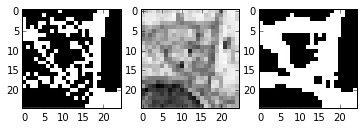

In [11]:
plt.subplot(1,3,1)
plt.imshow(patch_label, cmap = plt.cm.gray,interpolation='none')
plt.subplot(1,3,2)
plt.imshow(patch_raw, cmap = plt.cm.gray,interpolation='none')
plt.subplot(1,3,3)
plt.imshow(patch_label_original, cmap = plt.cm.gray,interpolation='none')

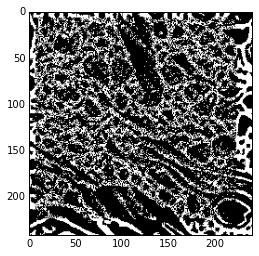

In [13]:
plt.imshow(new_reconstr, cmap = plt.cm.gray)

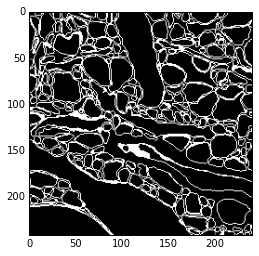

In [7]:
plt.imshow(true_2darray, cmap = plt.cm.gray)

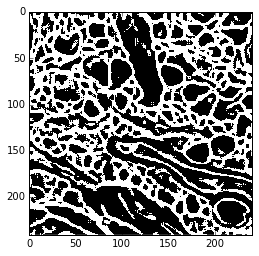

In [8]:
plt.imshow(original_2darray, cmap = plt.cm.gray,interpolation='none')